In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report
)

In [2]:
df = pd.read_excel('cleaned_data/cleaned_table_1a.xlsx')
df.head(10)

,Referrals received(2),Referrals entering treatment(3),Referrals finishing a course of treatment(4),Commissioning Region
0,1267193,815665,468881,England total
1,193280,124880,66395,London Commissioning Region
2,350915,237190,124940,Midlands and East of England Commissioning Re...
3,421155,243215,143465,North of England Commissioning Region
4,300240,209535,133150,South of England Commissioning Region
5,1600,845,930,Unknown


In [3]:
df = df.drop(index=5)  # Drop the unknown region row

df = df.rename(columns={
    "Referrals received(2)": "Referrals_received",
    "Referrals entering treatment(3)": "Referrals_entering",
    "Referrals finishing a course of treatment(4)": "Referrals_finishing",
    "Commissioning Region": "Commissioning_region"
})

df.head(10)

,Referrals_received,Referrals_entering,Referrals_finishing,Commissioning_region
0,1267193,815665,468881,England total
1,193280,124880,66395,London Commissioning Region
2,350915,237190,124940,Midlands and East of England Commissioning Re...
3,421155,243215,143465,North of England Commissioning Region
4,300240,209535,133150,South of England Commissioning Region


In [4]:
# Basic defensive handling to avoid division by zero
df["Entry_rate"] = df["Referrals_entering"] / df["Referrals_received"].replace(0, np.nan)
df["Completion_rate"] = df["Referrals_finishing"] / df["Referrals_entering"].replace(0, np.nan)
df["Throughput"] = df["Referrals_finishing"] / df["Referrals_received"].replace(0, np.nan)
df["Backlog_raw"] = df["Referrals_received"] - df["Referrals_entering"]
df["Backlog_ratio"] = df["Backlog_raw"] / df["Referrals_received"].replace(0, np.nan)

# Optional: round for readability
df_round = df.copy()
for col in ["Entry_rate", "Completion_rate", "Throughput", "Backlog_ratio"]:
    df_round[col] = (df_round[col] * 100).round(2)  # as percentages

df_round.head()


,Referrals_received,Referrals_entering,Referrals_finishing,Commissioning_region,Entry_rate,Completion_rate,Throughput,Backlog_raw,Backlog_ratio
0,1267193,815665,468881,England total,64.37,57.48,37.00,451528,35.63
1,193280,124880,66395,London Commissioning Region,64.61,53.17,34.35,68400,35.39
2,350915,237190,124940,Midlands and East of England Commissioning Re...,67.59,52.68,35.60,113725,32.41
3,421155,243215,143465,North of England Commissioning Region,57.75,58.99,34.06,177940,42.25
4,300240,209535,133150,South of England Commissioning Region,69.79,63.55,44.35,90705,30.21


       Referrals_received  Referrals_entering  Referrals_finishing  \
count        5.000000e+00            5.000000              5.00000   
mean         5.065566e+05       326097.000000         187366.20000   
std          4.332419e+05       277725.443617         160193.91062   
min          1.932800e+05       124880.000000          66395.00000   
25%          3.002400e+05       209535.000000         124940.00000   
50%          3.509150e+05       237190.000000         133150.00000   
75%          4.211550e+05       243215.000000         143465.00000   
max          1.267193e+06       815665.000000         468881.00000   

       Entry_rate  Completion_rate  Throughput    Backlog_raw  Backlog_ratio  
count    5.000000         5.000000    5.000000       5.000000       5.000000  
mean     0.648219         0.571718    0.370740  180459.600000       0.351781  
std      0.045447         0.044798    0.042291  156964.307148       0.045447  
min      0.577495         0.526751    0.340647   6840

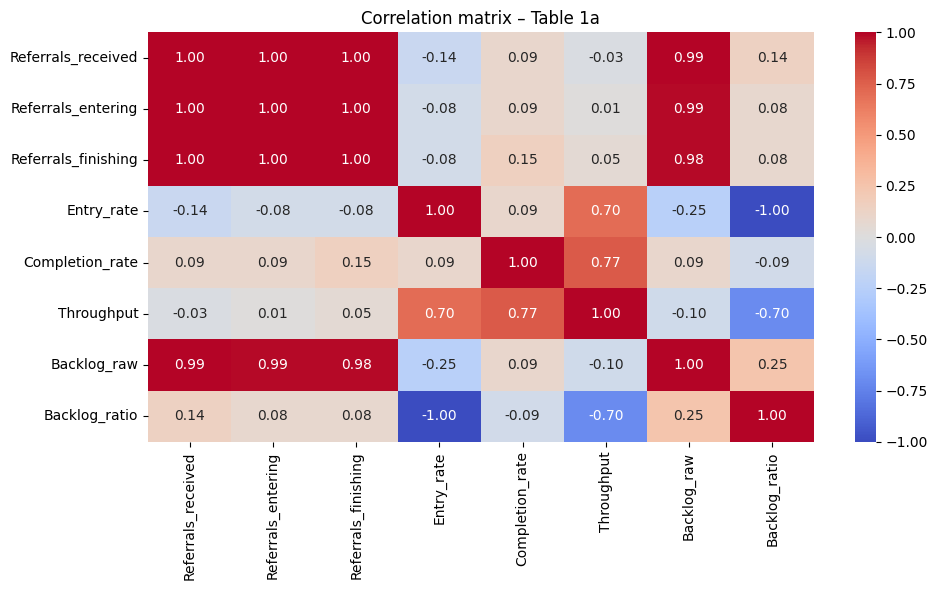

In [5]:
num_cols = ["Referrals_received", "Referrals_entering", "Referrals_finishing",
            "Entry_rate", "Completion_rate", "Throughput", "Backlog_raw", "Backlog_ratio"]

print(df[num_cols].describe())

plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix – Table 1a")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

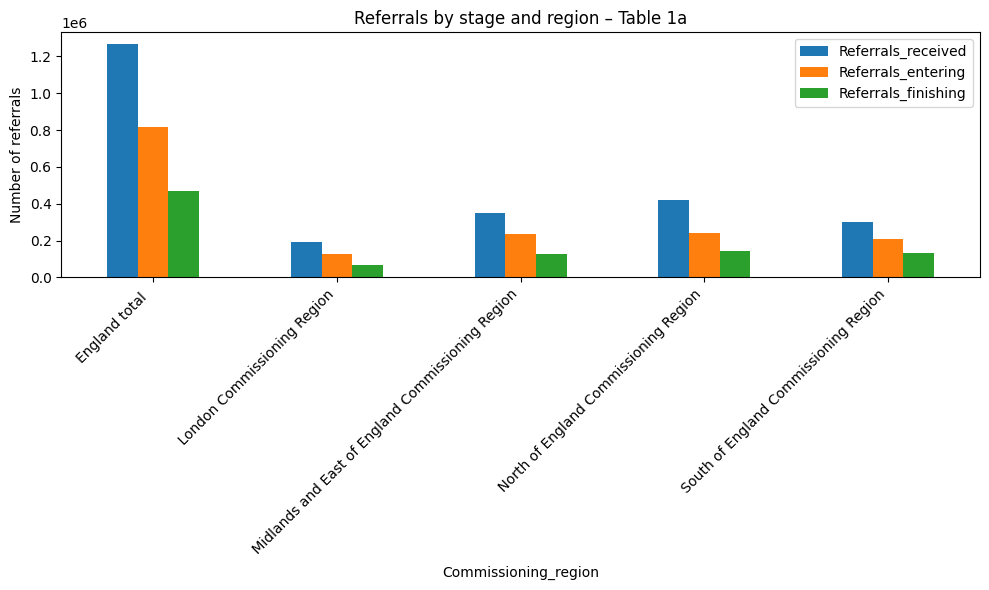

In [6]:
plt.figure(figsize=(10, 6))
df_plot = df.set_index("Commissioning_region")

df_plot[["Referrals_received", "Referrals_entering", "Referrals_finishing"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.ylabel("Number of referrals")
plt.title("Referrals by stage and region – Table 1a")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

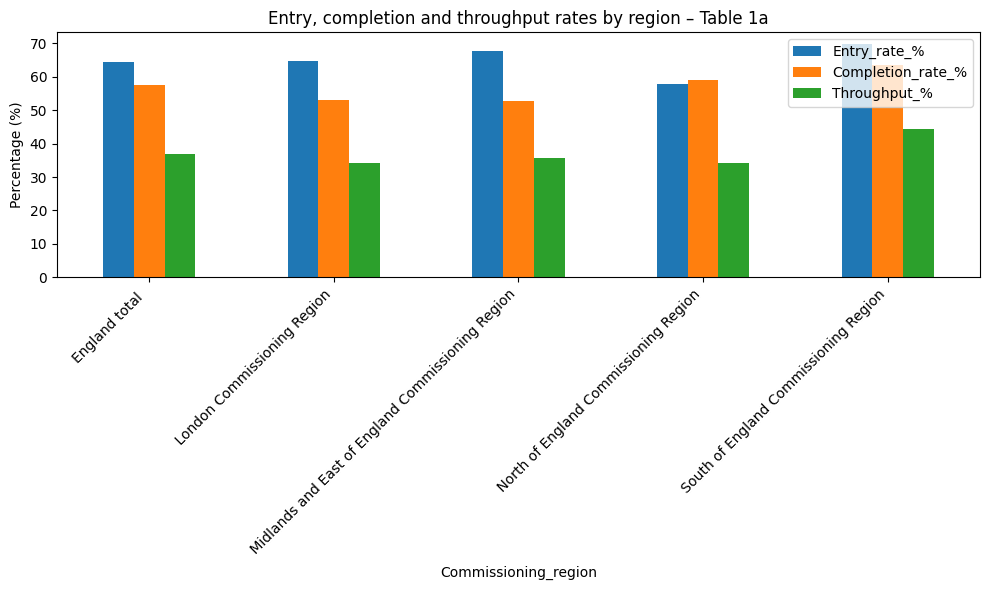

In [7]:
# Convert to percentages for plotting
ratio_plot = df.copy()
ratio_plot["Entry_rate_%"] = ratio_plot["Entry_rate"] * 100
ratio_plot["Completion_rate_%"] = ratio_plot["Completion_rate"] * 100
ratio_plot["Throughput_%"] = ratio_plot["Throughput"] * 100

ratio_plot = ratio_plot.set_index("Commissioning_region")

ratio_plot[["Entry_rate_%", "Completion_rate_%", "Throughput_%"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.ylabel("Percentage (%)")
plt.title("Entry, completion and throughput rates by region – Table 1a")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

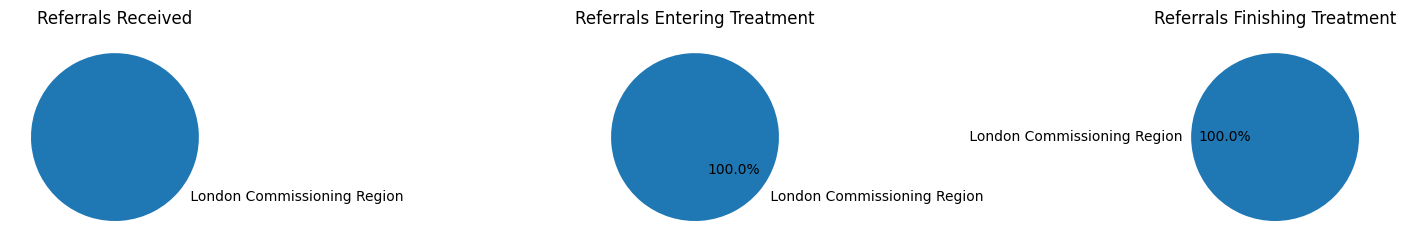

In [32]:
# Keep only required columns
df = df[["Commissioning_region", "Referrals_received", "Referrals_entering", "Referrals_finishing"]]

# Drop empty rows (metadata)
df = df.dropna(subset=["Referrals_received", "Referrals_entering", "Referrals_finishing"], how="any")

# Convert to numeric
df["Referrals_received"]   = pd.to_numeric(df["Referrals_received"], errors="coerce")
df["Referrals_entering"]   = pd.to_numeric(df["Referrals_entering"], errors="coerce")
df["Referrals_finishing"]  = pd.to_numeric(df["Referrals_finishing"], errors="coerce")

# Drop "England" total row
df = df[df["Commissioning_region"].str.contains("England", case=False) == False]

# Reset index
df = df.reset_index(drop=True)

# -----------------------
# PIE CHARTS
# -----------------------

plt.figure(figsize=(14, 4))

# Pie Chart 1: Referrals Received
plt.subplot(1, 3, 1)
plt.pie(df["Referrals_received"], labels=df["Commissioning_region"], startangle=140)
plt.title("Referrals Received")

# Pie Chart 2: Referrals Entering Treatment
plt.subplot(1, 3, 2)
plt.pie(df["Referrals_entering"], labels=df["Commissioning_region"], autopct="%1.1f%%", startangle=140)
plt.title("Referrals Entering Treatment")

# Pie Chart 3: Referrals Finishing Treatment
plt.subplot(1, 3, 3)
plt.pie(df["Referrals_finishing"], labels=df["Commissioning_region"], autopct="%1.1f%%")
plt.title("Referrals Finishing Treatment")

plt.tight_layout()
plt.show()